# Image Colorization using Autoencoders
By Kartikeya Shorya  
We always stumble upon some old photographs of our parents or some historic events and so. I always imagined of how they would actually looked in real life that is colored.
So in this quarantine, I decided to use Deep Learning methods and build a model which will be able to colorize Black and White Images to color images.

I absolutely love using the PyTorch which means... You've guessed it.

## Dataset
For this demonstration, I have used [Kaggle's flower recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset. 
It contains a total of **4242 images** belonging **5 classes**:
1. Daisy (769 images)
2. Dandelion (1055 images)
3. Rose (784 images)
4. Sunflower (734 images)
5. Tulip (984 images)

In [1]:
# importing the usual libraries
import cv2
import os
import matplotlib.pyplot as plt

images = []
for picture in os.listdir('./Images')[256:266]: # Selecting any 10 images
    picture = cv2.imread('./Images/' + picture, cv2.IMREAD_UNCHANGED)
    
    # changing the color space of the image from BGR to RGB
    # this change is required only for plotting purpose
    # Jupyter crashes when cv2.imshow() is used
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    images.append(picture)

### Visualizing the images

Below are some images from our dataset in RGB color space

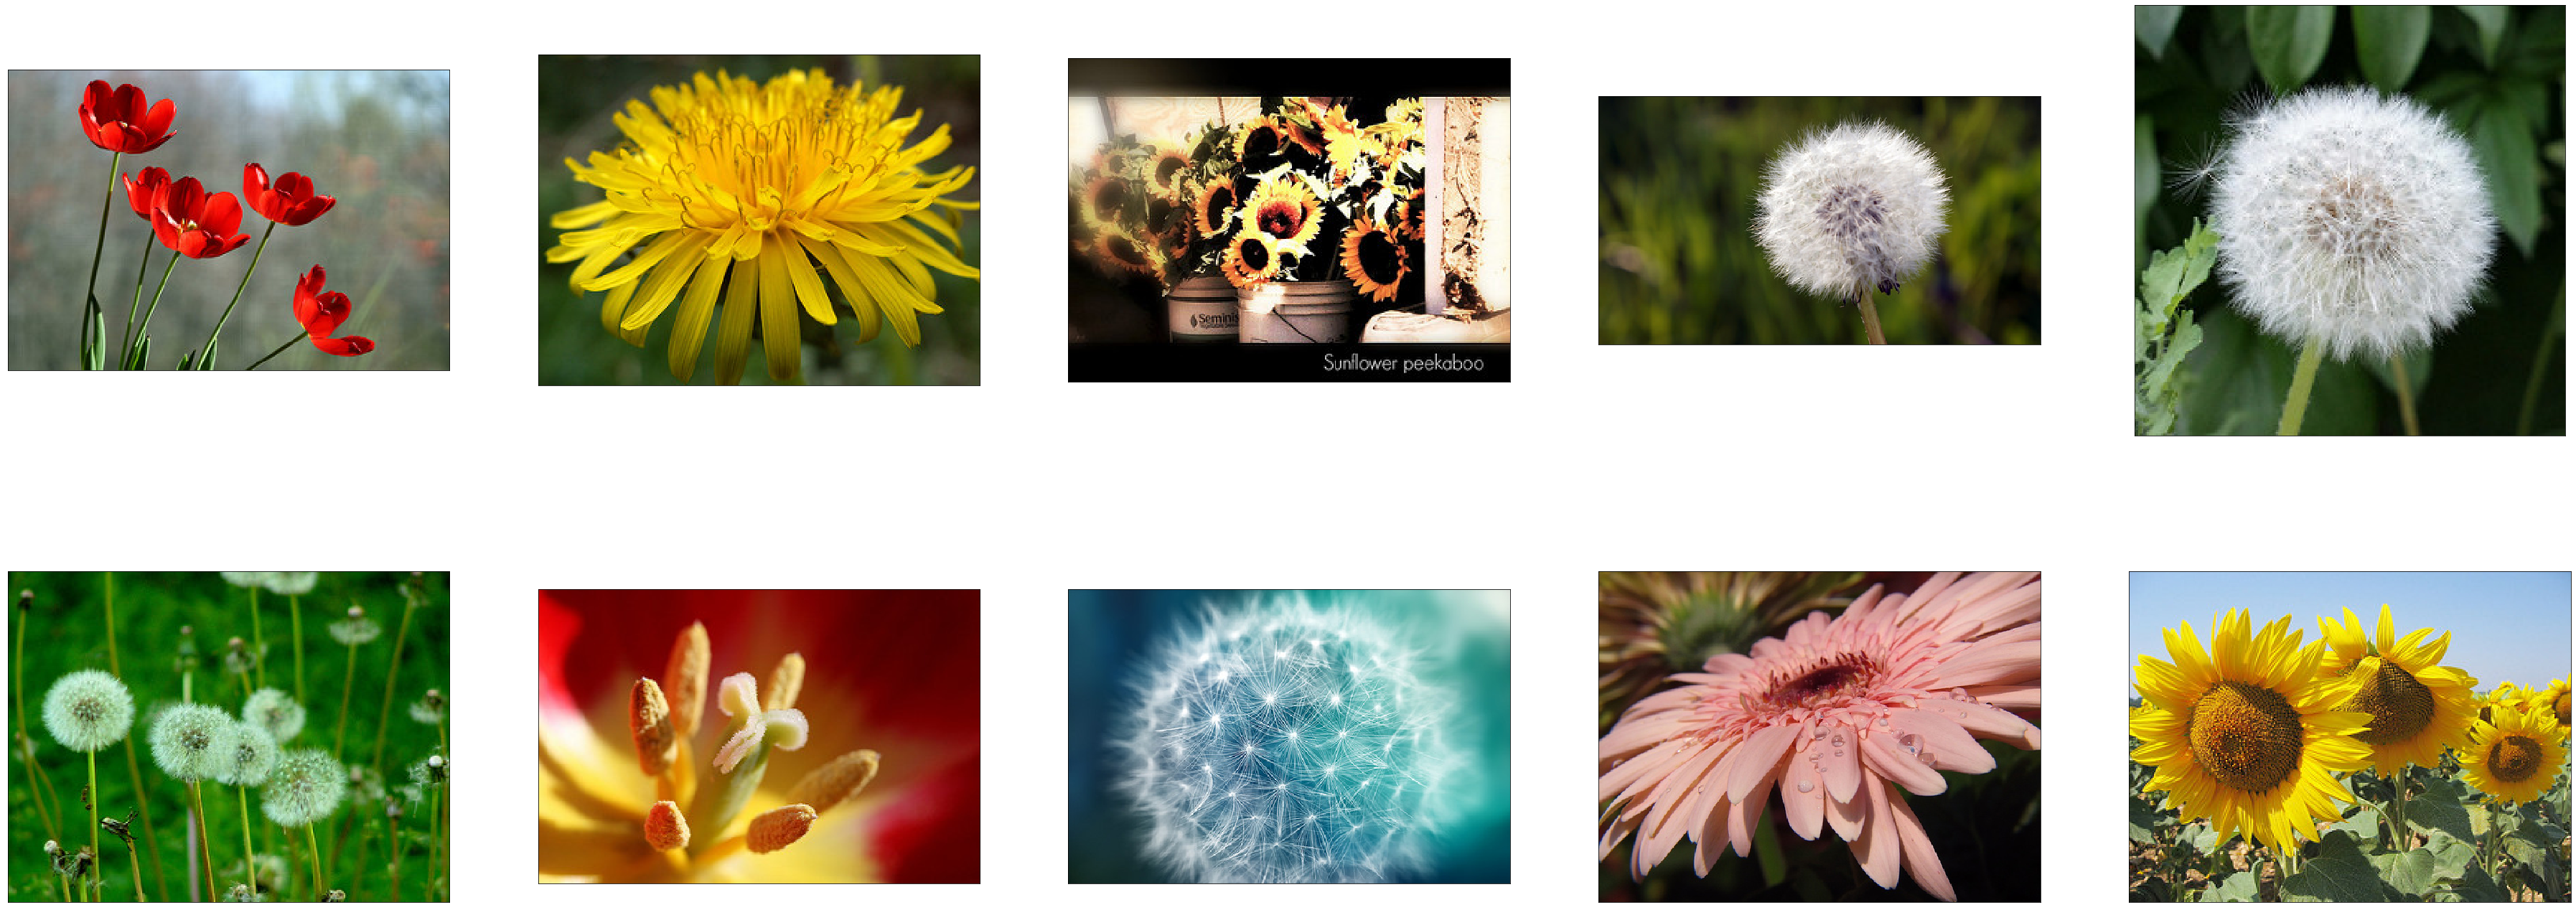

In [2]:
fig = plt.figure(figsize=(64, 64))
for i in range(10):
    ax = fig.add_subplot(5, 10/2, i+1, xticks=[], yticks=[])
    plt.imshow(images[i])

### Converting RGB Images to Lab Images
We will be using CIELab color space images in this demonstration

In [3]:
for i, image in enumerate(images):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    images[i] = image

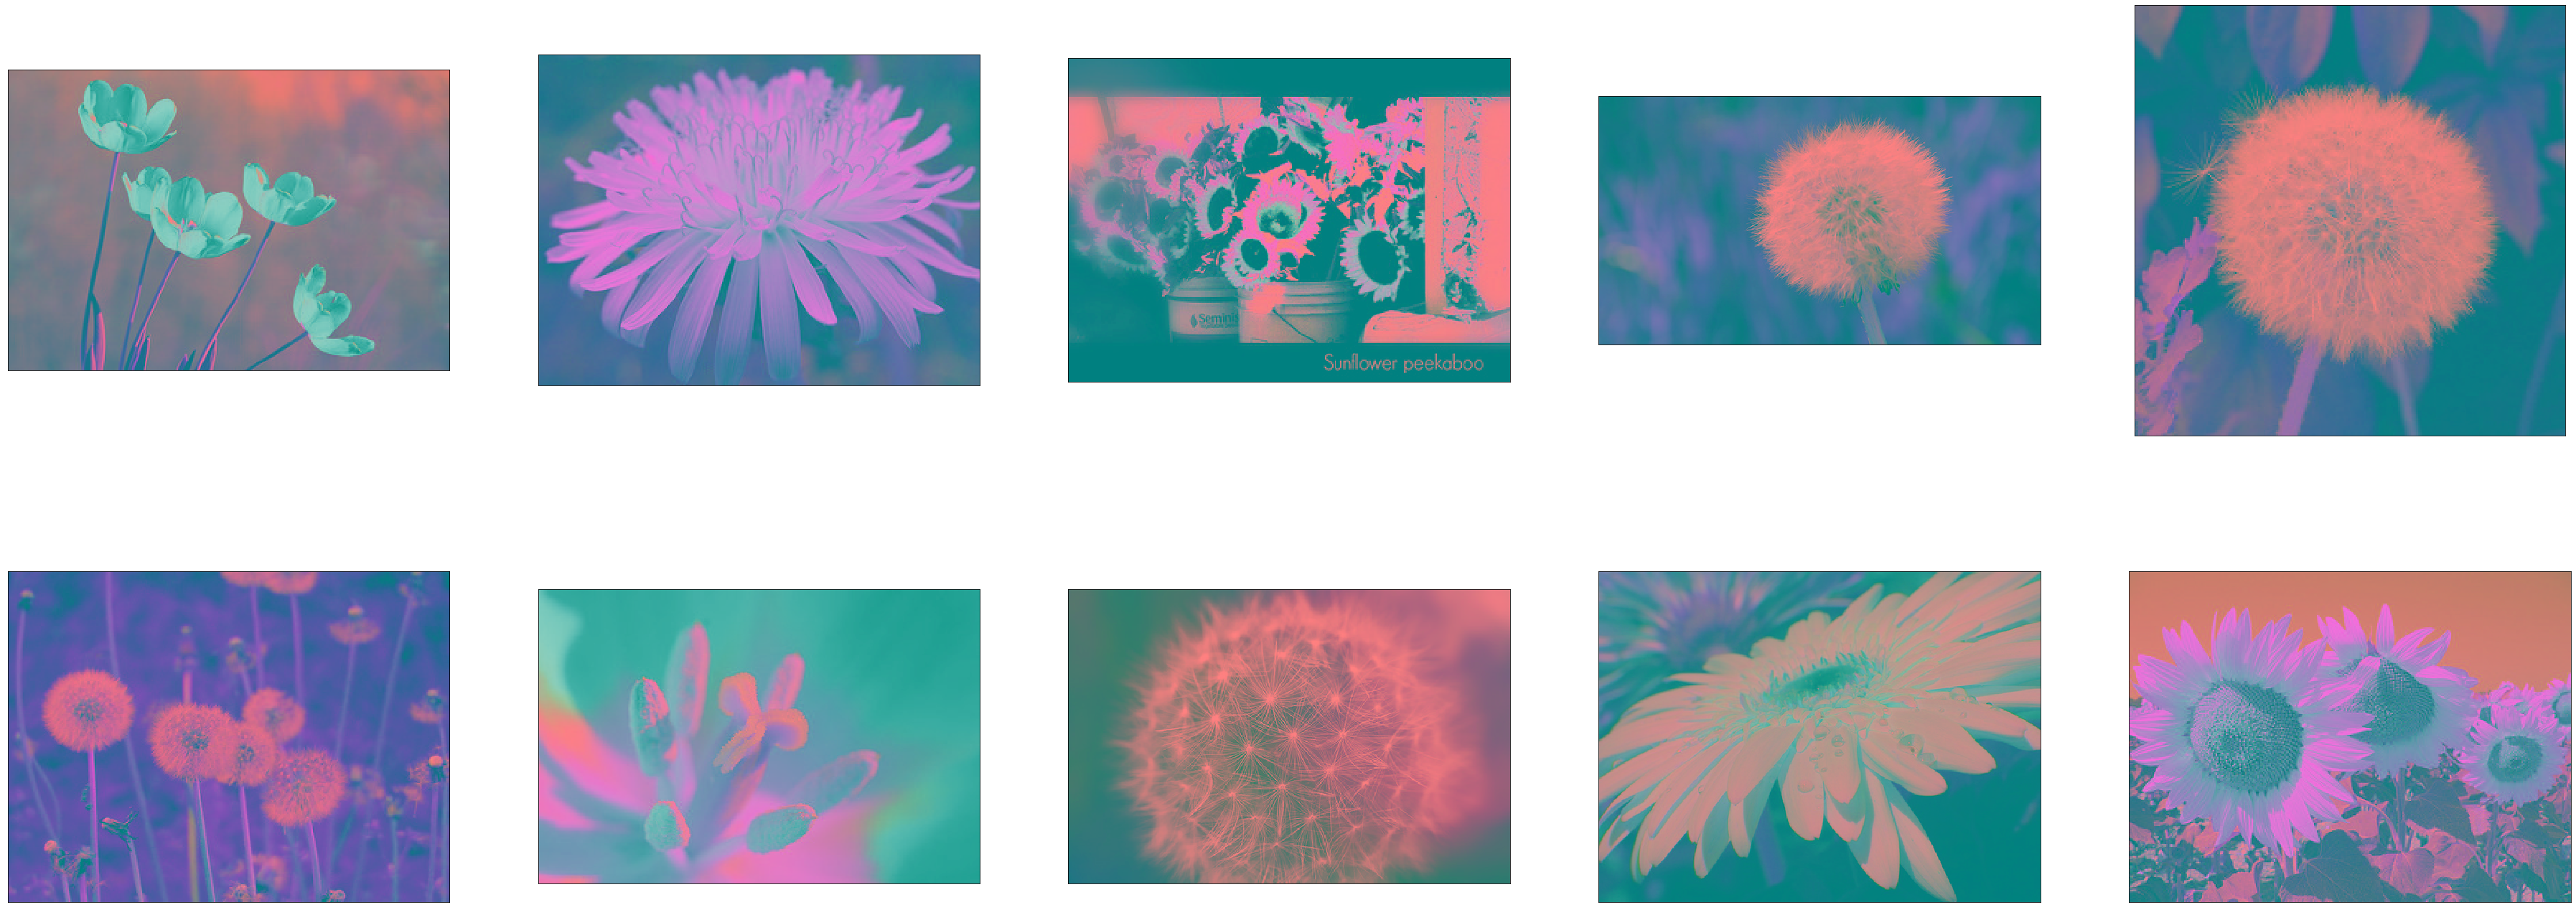

In [4]:
fig = plt.figure(figsize=(64, 64))

for i in range(10):
    ax = fig.add_subplot(5, 10/2, i+1, xticks=[], yticks=[])
    plt.imshow(images[i])

#### But why CIELab? Why not RGB?
Below is a diagram which explains all about the Lab Color Space

![CIELab Color Space](./notebook_ims/CIELAB.jpg)

In Lab, L stands for **lightness** with a and b being arbitary constants

* L contains all the information of the image in Black and White form (Not exactly grayscale but it is kinda similar)
* a contains information about the green-red color spectrum
* b contains information about the blue-yellow color spectrum

The range of values of all channels are as follows:
> L : 0 (black) to 100 (white)  
> a: -128 (green) to 127 (red)  
> b: -128 (blue) to 127 (yellow)

So, we can use L channel of the image as our grayscale image which will be our input image. And we will be generating a and b channels with our model.  
In the end, We can combine all the channels and convert it back to RGB color space for the color images.  
Here, we are generating 2 channels rather than 3 channels which will help decrease the computational load!

### Data Preparation
I wrote a short python script where I have processed the images.  
These include:
 1. Converting RGB images to Lab images
 2. Preprocessing the Lab images
 3. Converting the images to channel first format (Pytorch uses channels first format unlike Keras which by default uses channels last)
 4. Saving the file to .npy format
 5. Spliting the training the validation sets
 
You can check about the script in detail, just open the **process_data.py**

In [ ]:
!python process_data.py

## Loading the data

In [5]:
# The usual imports
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, datasets

In [6]:
# This function will load the numpy array from .npy file
# and convert it to a tensor
def npy_loader(path):
    image = torch.Tensor(np.load(path))
    return image

# Using custom dataset with DatasetFolder!
train_data = datasets.DatasetFolder(root='./LabImages/train', loader=npy_loader, extensions='.npy')
valid_data = datasets.DatasetFolder(root='./LabImages/valid', loader=npy_loader, extensions='.npy')


# If you're planning to train the model...
# Please decrease the batch size to about 16 or 32
# unless you are having 8GB VRAM or want to
# face CUDA out of memory issue
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=False)

## Building the Model
BUT FIRST
#### What is an Autoencoder?
![Autoencoder Denoise](./notebook_ims/autoencoder_denoise.png)

Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible. 

*Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.*

We will be building a **vannila convolutional autoencoder** with convolutional layers, maxpooling layers and upscaling layers!

Here is small example of an convolutional autoencoder  
![Convolutional Autoencoder](./notebook_ims/conv_autoencoder.png)

In [7]:
# Storing the configuration of the Autoencoder in a dictionary
# numbers represent output channels of the convolutional layer
# M is for MaxPooling
# and U is for Upscaling (or Unpooling, whichever makes sense to you)

configs = {
    'Encoder' : ['M', 64,'M', 128, 'M', 256, 'M', 512, 512, 512],
    'Decoder' : ['U', 256,'U', 128, 'U', 32, 2, 'U']    
}

In [8]:
class Colorizer(nn.Module):
    def __init__(self):
        super(Colorizer, self).__init__()
        
        # Storing our image specifications
        self.in_features=1
        self.img_size=224
        
        # creating encoder
        self.encoder = self.create_coder('Encoder')
        # creating decoder
        self.decoder = self.create_coder('Decoder')
        
    # the forward pass    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    # a function to create our encoding and decoding block   
    def create_coder(self, name):
        layers = []
        
        # looping through the dictionay with configs of the coder block
        for out_features in configs[name]:
            if type(out_features) == int:
                layers.append(nn.Conv2d(self.in_features, out_features, kernel_size=3, stride=1, padding=1))
                
                if out_features!=2:
                    # our activation function
                    
                    # reason for using != is that we don't want ReLU
                    # in the output layer
                    layers.append(nn.ReLU())
                    
                else:
                    # As we have already preprocessed the images
                    # L channel now range from [0,1]
                    # whereas, a and b ranges from [-1,1]
                    
                    # Both the output ranges are covered in tanh function
                    layers.append(nn.Tanh())
                self.in_features = out_features
            
            elif out_features == 'M':
                layers.append(nn.MaxPool2d(2, 2))
                
                # reducting dimensions of the img_size variable
                self.img_size = self.img_size//2
                
            elif out_features == 'U':
                # restoring back the img_size
                self.img_size = self.img_size*2
                layers.append(nn.Upsample(size=self.img_size, mode='bilinear', align_corners=False))
            
        # Unpacking the layers list and returning a sequential model
        # for each coder block
        return nn.Sequential(*layers)

**Note:** In Upsample layer, I could just have used ```scale_factor=2```

### Architecture of the Model

In [9]:
model = Colorizer()
model

Colorizer(
  (encoder): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Upsample(size=28, mode=bilinea

## Training the Model

**Run the below cells if you really want to train the model, or else skip to <u>Testing the Model section</u>**

**Disclaimer:** _It is recommended to use a GPU rather than CPU. If you plan to use CPU even after having a GPU, if the heat generated by your CPU yeets your system._

I am using my Nvidia GTX 1070 with Max-Q Architecture for training the model.

I have used [Mean Squared Error](https://pytorch.org/docs/master/generated/torch.nn.MSELoss.html) as my criterion/loss function.  
Optimizer? [Adam optimizer](https://pytorch.org/docs/stable/optim.html) (Check out the link to know more)

In [10]:
model = model.to('cuda') # moving the model to GPU
criterion = nn.MSELoss() # defining our loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # defining our optimizer on the parameters of our model

The model is trained on 50 epochs with training and validation loss being monitored.

After every epoch, we are checking if the validation loss has decreased. If decreased, save the model or else continue as usual.  
The training speed is okayish as we are using a very large batch size.

In [11]:
EPOCHS=50

min_valid_loss = np.inf
train_loss_log = []
valid_loss_log = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    valid_loss = 0
        
    for images, _ in trainloader:
        # moving the images to gpu
        images = images.to('cuda', dtype = torch.float)
            
        # Resetting the optimizer to prevent gradient accumulation    
        optimizer.zero_grad()
        
        # passing L channel of the image by slicing the image array
        # and storing the output in output (array)
        output = model(images[:, :1, :, :])
        
        # Calculating loss by comparing our output with
        # a,b channels of the image
        loss = criterion(output, images[:, 1:, :, :])
        
        # backpropagting...
        loss.backward()
        
        # using optimizer to change the values of parameters
        # to decrease the loss
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    
    # For validation we don't need to calculation gradients
    with torch.no_grad():
        model.eval()
        
        for images, _ in validloader:
            images = images.to('cuda', dtype=torch.float)
            
            output = model(images[:, :1, :, :])
            loss = criterion(output, images[:, 1:, :, :])
            valid_loss += loss.item() * images.size(0)
    
    train_loss /= len(trainloader)
    valid_loss /= len(validloader)
    
    train_loss_log.append(train_loss)
    valid_loss_log.append(valid_loss)
        
    print(f'Epochs:({epoch+1:2d}/{EPOCHS}) => '
         f'Training Loss: {train_loss:.5f}... '
         f'Valid Loss: {valid_loss:.5f}... ')
    
    # Saving the best model after each epoch
    if min_valid_loss > valid_loss:
        print('Saving...\n')
        torch.save(model.state_dict(), f'Colorizer{EPOCHS}.pth')
        min_valid_loss = valid_loss

Epochs:( 1/50) => Training Loss: 6.45863... Valid Loss: 3.27190... 
Saving...

Epochs:( 2/50) => Training Loss: 3.80183... Valid Loss: 3.19666... 
Saving...

Epochs:( 3/50) => Training Loss: 3.77680... Valid Loss: 3.17040... 
Saving...

Epochs:( 4/50) => Training Loss: 3.73256... Valid Loss: 3.18764... 
Epochs:( 5/50) => Training Loss: 3.72770... Valid Loss: 3.20234... 
Epochs:( 6/50) => Training Loss: 3.71647... Valid Loss: 3.14477... 
Saving...

Epochs:( 7/50) => Training Loss: 3.69779... Valid Loss: 3.24583... 
Epochs:( 8/50) => Training Loss: 3.70737... Valid Loss: 3.18183... 
Epochs:( 9/50) => Training Loss: 3.69624... Valid Loss: 3.12294... 
Saving...

Epochs:(10/50) => Training Loss: 3.65407... Valid Loss: 3.13330... 
Epochs:(11/50) => Training Loss: 3.64717... Valid Loss: 3.08936... 
Saving...

Epochs:(12/50) => Training Loss: 3.61801... Valid Loss: 3.06222... 
Saving...

Epochs:(13/50) => Training Loss: 3.61374... Valid Loss: 3.07023... 
Epochs:(14/50) => Training Loss: 3.5944

### Loss Plot
As we can see that, the training loss goes down but eventually model starts to overfit

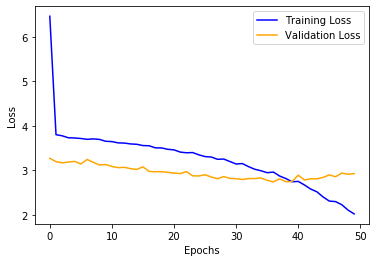

In [12]:
plt.plot(train_loss_log, color='blue', label='Training Loss')
plt.plot(valid_loss_log, color='orange', label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='best')
_ = plt.show()

## Testing the Model
It's time to test the model!

Let's load our best performing model's checkpoint file

In [10]:
model.load_state_dict(torch.load('Colorizer50.pth'))

<All keys matched successfully>

I am using the Validation Data only for visualization of the output

In [11]:
data = datasets.DatasetFolder(root='./LabImages/valid', loader=npy_loader, extensions='.npy')

dataloader = torch.utils.data.DataLoader(data, shuffle=False, batch_size=1)
dataiter = iter(dataloader)

#### Run this cell as many times to iterate through the images

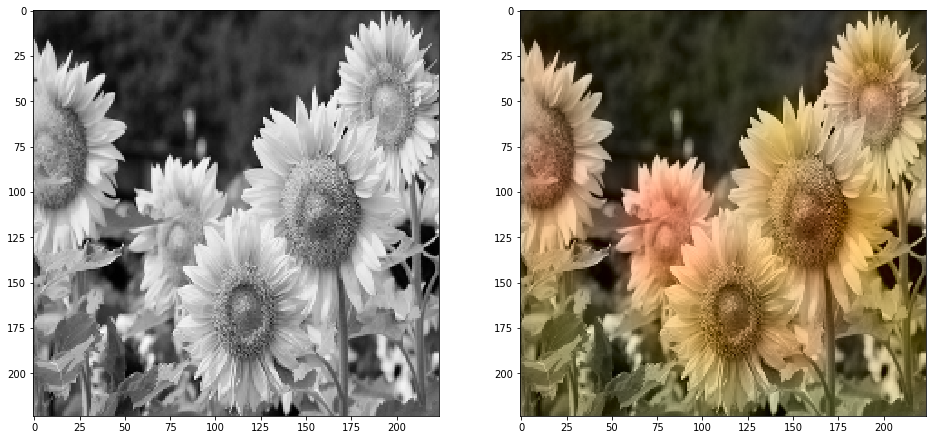

In [12]:
image, _ = dataiter.next()
gray = torch.zeros([224, 224])

# Storing the L channel into gray
for i in range(224):
    for j in range(224):
        gray[i,j] = image[:,:1,i,j]
        
        
# Reshaping it for pytorch
# (batch size, channels, image height, image width)
gray = gray.reshape(1, 1, 224, 224)

# passing the input and obtaining the output
output = model(gray)

# detacing the variables to stop gradient calculation
output = output.detach().numpy()
gray = gray.detach().numpy()

# reshaping the channels
output = output.reshape(2, 224, 224)
gray = gray.reshape(1, 224, 224)

# converting back to channels last
output = np.moveaxis(output, 0, 2)
gray = np.moveaxis(gray, 0, 2)

gray = gray.reshape(224, 224)

lab = np.zeros([224, 224, 3])

# copying the channels into lab
for i in range(224):
    for j in range(224):
        lab[i,j,0] = gray[i,j]
        lab[i,j,1] = output[i,j,0]
        lab[i,j,2] = output[i,j,1]
        
# for Lab to RGB conversion    
from skimage.color import lab2rgb

# unnormalizing the image
lab[:, :, 0] = lab[:, :, 0]*100
lab[:, :, 1] = lab[:, :, 1]*128
lab[:, :, 2] = lab[:, :, 2]*128

# Converting Lab back to RGB
color = lab2rgb(lab)

# Plotting the results
fig, axis = plt.subplots(1,2, figsize=(16, 16))

axis[0].imshow(gray, cmap='gray')
axis[1].imshow(color)

## Shortcoming of the Model
This definitely isn't the best model out there! Even the result obtained above is **one of the best** if not the best result given by the model.

The reason is simple as Vanilla Autoencoders aren't deep enough to properly extract spatial features which are required to put specific colors in specific portions of the images. Even if they are deep, the information is compressed too much into the latent space vectore resulting in Loss of information.

One approach as described by [Iizuka et al](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/data/colorization_sig2016.pdf) is to use a separate convolutional and dense layers to extract global features and fuse them with the low and mid level features. It will help in retaining the color information as well as feature information. For more information read the paper!


Thanks for going through this notebook!